In [79]:
import numpy as np
from ratings_graph import RatingsGraph
import random
import matplotlib.pyplot as plt
#from true_ratings_prediction import debias_ratings_baseline

# Generate Biased 

In [80]:
def generate_biased_dataset(num_users, num_entities, gen_user_biases, gen_entity_features, num_features=1, seed=10, p_rate=0.2): 
    # The true ratings of the entities
    np.random.seed(seed)
    ground_truth_ratings = np.random.random(num_entities)
    
    # The number of features that define a movie
    # num_features = 1
    
    # Each user has a bias value along a certain feature dimension
    user_biases = np.zeros((num_users, num_features))
    for user_idx in range(num_users):
        for feature_idx in range(num_features):
            user_biases[user_idx][feature_idx] = gen_user_biases()
    
    # Setting the features for each entity along each feature dimension
    entity_features = np.zeros((num_entities, num_features))
    for entity_idx in range(num_entities):
        # Currently saying the maximum magnitude of the entity features is 1.0 / num_features
        #entity_features[entity_idx, :] = np.random.uniform(0, 1.0/num_features, num_features)
        entity_features[entity_idx, :] = gen_entity_features(num_features)
    
    # TODO: Think about how to intelligently normalize these features
    '''
    if num_features > 1:
        linfnorm = np.linalg.norm(entity_features, axis=1, ord=2)
        entity_features = entity_features.astype(np.float) / linfnorm[:,None]
    '''
    # Setting the user_item ratings and the user_item adjacency matrix
    user_entity_ratings = np.zeros((num_users, num_entities))
    user_entity_adj_matrix = np.zeros((num_users, num_entities))
    for user_idx in range(num_users):
        for entity_idx in range(num_entities):
            if np.random.random() < p_rate:
                user_entity_ratings[user_idx][entity_idx] = ground_truth_ratings[entity_idx] + \
                                                    (np.dot(entity_features[entity_idx, :], user_biases[user_idx,:]))
                user_entity_ratings[user_idx][entity_idx] = max(min(user_entity_ratings[user_idx][entity_idx], 1), 0)
                user_entity_adj_matrix[user_idx][entity_idx] = 1

    return user_entity_ratings, ground_truth_ratings, user_entity_adj_matrix, entity_features, user_biases

In [81]:
import numpy as np
import pandas as pd

EPSILON = 0.000001

def single_iteration(ratings_graph, biases, true_ratings, alpha, beta):
    # Remove nans
    biases = np.nan_to_num(biases)
    true_ratings = np.nan_to_num(true_ratings)
    
    # Update Ratings
    graph_shape = ratings_graph.get_graph_shape()
    indiv_true_ratings = np.maximum(np.zeros(graph_shape), np.minimum(np.ones(graph_shape),
                                        ratings_graph.get_user_entity_ratings() - alpha * biases[:, None]))
    rating_denoms = ratings_graph.get_entity_rating_counts()
    next_true_ratings = np.sum(ratings_graph.get_user_entity_adj_matrix() * indiv_true_ratings, axis=0) / rating_denoms

    # Update Biases
    indiv_biases = ratings_graph.get_user_entity_ratings() - next_true_ratings
    bias_denoms = ratings_graph.get_user_rating_counts()
    next_biases = (1-beta)*biases + beta*(np.sum(ratings_graph.get_user_entity_adj_matrix() * indiv_biases, axis=1) / bias_denoms)
    
    if (np.isnan(biases).any() or np.isnan(true_ratings).any()):
        import pdb; pdb.set_trace()
    
    converged = True
    if ((true_ratings is not None) and np.any(np.abs(true_ratings - next_true_ratings) > EPSILON)) or \
        np.any(np.abs(biases - next_biases) > EPSILON):
        converged = False

    return converged, next_true_ratings, next_biases

def single_iteration_multi_dim_bias(ratings_graph, biases, true_ratings, alpha, beta):
    # Update Rating
    graph_shape = ratings_graph.get_graph_shape()
    indiv_true_ratings = np.maximum(np.zeros(graph_shape), np.minimum(np.ones(graph_shape),
                                        ratings_graph.get_user_entity_ratings() - alpha * biases))
    rating_denoms = ratings_graph.get_entity_rating_counts()
    next_true_ratings = np.sum(ratings_graph.get_user_entity_adj_matrix() * indiv_true_ratings, axis=0) / rating_denoms

    # Update Biases
    indiv_biases = (ratings_graph.get_user_entity_adj_matrix()*(ratings_graph.get_user_entity_ratings() - next_true_ratings)).dot(ratings_graph.get_entity_features())
    bias_denoms = (ratings_graph.get_user_entity_adj_matrix()).dot(ratings_graph.get_entity_features())
    next_biases = (1-beta)*biases + beta*(indiv_biases) / bias_denoms
    
    converged = True
    if ((true_ratings is not None) and np.any(np.abs(true_ratings - next_true_ratings) > EPSILON)) or \
        np.any(np.abs(biases - next_biases) > EPSILON):
        converged = False

    return converged, next_true_ratings, next_biases


def mishra_prediction(ratings_graph, initial_alpha=0.99, \
                                     decay_rate=1.00, \
                                     max_iters = 200000, \
                                     beta = 0.1, \
                                     multi_dim_bias=False, \
                                     seed=10):
    np.random.seed(seed)
    ground_truth_ratings = ratings_graph.get_ground_truth_ratings()
    true_ratings = [np.random.uniform((ratings_graph.num_entities,))]
    if not multi_dim_bias:
        biases = [np.random.uniform(low = -1, high = 1, size = (ratings_graph.num_users,))]
    else:
        biases = [np.random.uniform(low = -1, high = 1, size = (ratings_graph.num_users, ratings_graph.num_entities))]
    errors = []

    converged = False
    num_iters = 0
    alpha = initial_alpha
    while not converged and num_iters < max_iters:
        true_rate_or_none = None if not true_ratings else true_ratings[-1]
        if not multi_dim_bias:
            iter_out = single_iteration(ratings_graph, biases[-1], true_rate_or_none, alpha, beta)
        else:
            iter_out = single_iteration_multi_dim_bias(ratings_graph, biases[-1], true_rate_or_none, alpha, beta)

        converged, next_true_ratings, next_biases = iter_out
        true_ratings.append(next_true_ratings)
        biases.append(next_biases)
        if ground_truth_ratings is not None:
            errors.append(np.sqrt(np.mean((next_true_ratings - ground_truth_ratings)**2)))
        num_iters += 1
        alpha = alpha/decay_rate

    return biases, true_ratings, errors
def mean_prediction(ratings_graph):
    user_entity_ratings = ratings_graph.get_user_entity_ratings()
    user_entity_adj_matrix = ratings_graph.get_user_entity_adj_matrix()
    user_entity_adj_matrix_na = user_entity_adj_matrix.copy()
    user_entity_adj_matrix_na[user_entity_adj_matrix==0]=np.nan

    mean_pred = np.nanmean(user_entity_ratings*(user_entity_adj_matrix_na), axis=0)
    return mean_pred
                  
def median_prediction(ratings_graph):
    user_entity_ratings = ratings_graph.get_user_entity_ratings()
    user_entity_adj_matrix = ratings_graph.get_user_entity_adj_matrix()
    user_entity_adj_matrix_na = user_entity_adj_matrix.copy()
    user_entity_adj_matrix_na[user_entity_adj_matrix==0]=np.nan
    
    median_pred = np.nanmedian(user_entity_ratings*(user_entity_adj_matrix_na), axis=0)
    return median_pred

def get_pred_error(pred, ratings_graph):
    error = np.sqrt(np.mean((pred - ratings_graph.get_ground_truth_ratings())**2))
    return error

In [82]:
gen_constant_entity_features = lambda num_features: np.ones(num_features)
gen_random_entity_features = lambda num_features: np.random.uniform(0, 1.0/num_features, num_features)
gen_beta_dist_bias = lambda: np.random.beta(0.5, 0.5) - 0.5
gen_polarized_dist_bias = lambda: 0.5 if random.randint(0, 1) else -0.5

user_entity_ratings, ground_truth_ratings, user_entity_adj_matrix, entity_features, user_biases = \
    generate_biased_dataset(200, 20, gen_beta_dist_bias, gen_random_entity_features, 3, seed=20)
ratings_graph = RatingsGraph(user_entity_ratings, user_entity_adj_matrix, ground_truth_ratings, entity_features)

In [83]:
mean_pred = mean_prediction(ratings_graph)
median_pred = median_prediction(ratings_graph)
biases, true_ratings, errors = mishra_prediction(ratings_graph)
mishra_pred = true_ratings[-1]
mean_pred_error = get_pred_error(mean_pred, ratings_graph)
median_pred_error = get_pred_error(median_pred, ratings_graph)
print ('Mean error: ', mean_pred_error)
print ('Median error: ', median_pred_error)
print ('Mishra error: ', get_pred_error(mishra_pred, ratings_graph))

/Users/travischen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Mean error:  0.023951744833824163
Median error:  0.025873570817327936
Mishra error:  0.020904802552631295


/Users/travischen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


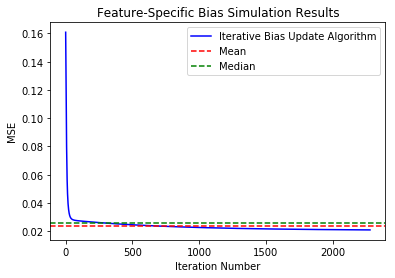

In [84]:
plt.title('Feature-Specific Bias Simulation Results')
plt.plot(errors, color = 'b', label = 'Iterative Bias Update Algorithm')
plt.axhline(mean_pred_error, color='r', linestyle='--', label='Mean')
plt.axhline(median_pred_error, color='g', linestyle='--', label='Median')
plt.legend()
plt.xlabel('Iteration Number')
plt.ylabel('MSE')
plt.show()